In [ ]:
%load_ext autoreload
%autoreload 2

import music21 as mu
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from data_helper import *
from music_helper import *

sns.set(font='Yu Gothic')

In [113]:
dataId = 2
pathes = [
    f'./tmp/Result_FHMM1/{dataId:03d}-1_fingering.txt',f'./tmp/Result_FHMM2/{dataId:03d}-1_fingering.txt',
    f'./tmp/Result_FHMM3/{dataId:03d}-1_fingering.txt',
    f"./tmp/PianoFingeringDataset/FingeringFiles/{dataId:03d}-1_fingering.txt",
    f"./tmp/PianoFingeringDataset/FingeringFiles/{dataId:03d}-2_fingering.txt",
    f"./tmp/PianoFingeringDataset/FingeringFiles/{dataId:03d}-5_fingering.txt",
    f"./tmp/PianoFingeringDataset/FingeringFiles/{dataId:03d}-8_fingering.txt",
    f'./data/{dataId:03d}-Czerny_fingering.csv',
    f'./data/{dataId:03d}-ZenonTakagi_fingering.csv',f'./data/{dataId:03d}-ZenonIchida_fingering.csv',
]
players = [
    "FHMM1st","FHMM2nd",
    "FHMM3rd",
    "PIG_YI",
    "PIG_ES",
    "PIG_HI",
    "PIG_NH",
    "ツェルニー版",
    "全音高木版","全音市田版",
]
filenames = [f"{dataId:03d}-{name}" for name in players]
tables = [read_PIG(path) for path in pathes]

In [114]:
columns = ["寄せ", "拡げ", "潜り", "超え", "静止"]
playerNum = len(players)
noteNum = len(tables[0])
total = np.zeros(shape = (playerNum, len(columns)))
aTable = np.zeros(shape = (playerNum, noteNum))
for playerId, name in enumerate(players):
    table = tables[playerId]
    aIdx = 0
    aList = np.zeros(len(table))
    for ch in [0, 1]:
        actions = np.zeros(len(columns))
        notes = table[table.ch == ch]
        rest = False
        for pi in range(1, len(notes)):
            n = notes.iloc[pi]
            n_ = notes.iloc[pi - 1]
            td_ = n.t0 - n_.t1
            if td_ >= 1 / 32: # 休符を挟まない
                rest = True
                continue
            if not rest:
                move = getMoveTypeByPIGNote(n, n_, True)
                actions[move] += 1
                aList[aIdx] = move
            rest = False
            aIdx += 1
        total[playerId] += actions
    #aTable[playerId] = aList
total

array([[  3., 113.,  14.,   9., 447.],
       [  3., 112.,  12.,  12., 447.],
       [  3., 113.,  14.,  13., 443.],
       [ 21., 115.,  16.,  11., 423.],
       [ 51.,  76.,   5.,  11., 443.],
       [ 27., 115.,   7.,   8., 429.],
       [ 30., 113.,   7.,  11., 425.],
       [ 49., 123.,   4.,   4., 406.],
       [ 56., 112.,   6.,   3., 409.],
       [ 46., 110.,   4.,   8., 418.]])

In [ ]:
match = np.zeros(shape = (playerNum, playerNum))
for i, j in itertools.product(range(playerNum), range(playerNum)):
    match[i, j] = np.count_nonzero(aTable[i] == aTable[j])

df = pd.DataFrame(data = match / noteNum, columns = players, index = players)
sns.heatmap(df, cmap=plt.get_cmap("inferno"), vmin = 0.75, vmax = 1.0, annot = True)

In [ ]:
from sklearn import manifold
mds = manifold.MDS(n_components=2, dissimilarity="precomputed", random_state = 1)

dfp = 1 - df
pos = mds.fit_transform(dfp)

plt.scatter(pos[:, 0], pos[:, 1], marker = 'o')
for i, xy in enumerate(zip(pos[:, 0], pos[:, 1])):
    plt.text(xy[0], xy[1] + 0.01, df.columns[i])

In [115]:
dfa = pd.DataFrame(total, columns=columns, index=players)
dfa = dfa.drop('静止', axis = 1)
dfa['合計'] = dfa[columns[0:4]].sum(axis = 1)
dfa.applymap(lambda n: int(n))

,寄せ,拡げ,潜り,超え,合計
FHMM1st,3,113,14,9,139
FHMM2nd,3,112,12,12,139
FHMM3rd,3,113,14,13,143
PIG_YI,21,115,16,11,163
PIG_ES,51,76,5,11,143
PIG_HI,27,115,7,8,157
PIG_NH,30,113,7,11,161
ツェルニー版,49,123,4,4,180
全音高木版,56,112,6,3,177
全音市田版,46,110,4,8,168


In [160]:
def appendPIGNotesWithArmMove(pig_notes, ch):
    pig_notes = pig_notes[pig_notes.ch == ch]
    moves = np.zeros(len(pig_notes))
    sign = np.sign(ch + 0.5)
    v_ = 0
    for pi in range(len(pig_notes)):
        n = pig_notes.iloc[pi]
        if pi > 0:
            n_ = pig_notes.iloc[pi - 1]
            move = getMoveType(n.fingers, n_.fingers, n.pos, n_.pos)
            pd = n.pos - n_.pos
            fd = (n.fingers[0] - n_.fingers[-1])
            #v = pd - fd
            #if (v > 0 and v_ < 0) or (v < 0 and v_ > 0):
            #    moves[pi] = v
            #if v != 0:
            #    v_ = v
            if move == 1:
                moves[pi] = abs(pd) - abs(fd)
    return moves

#for i in range(len(pathes)):
moves = appendPIGNotesWithArmMove(tables[7], 1)
moves.sum()

133.0

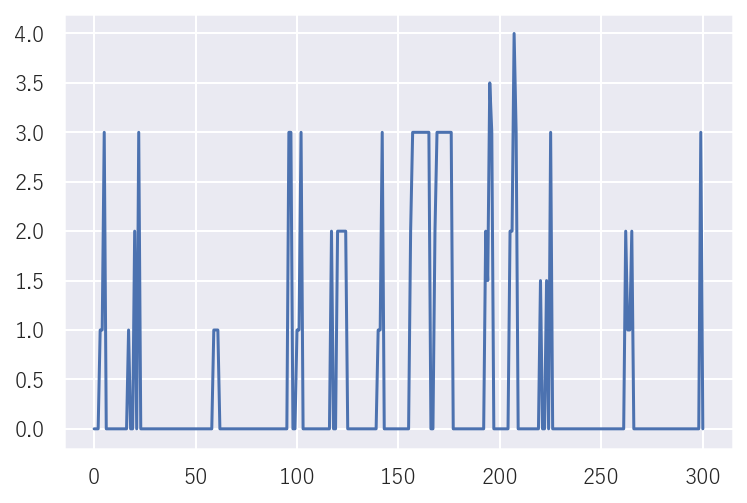

In [161]:
plt.plot(moves)